### Imports

In [1]:
## Standard Library
import os
import json

## External Libraries
import torch
import os
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import Grayscale

# from torchmetrics.classification import Dice
import zipfile


# Visualize predictions
import matplotlib.pyplot as plt

from PIL import Image

import datetime



# ## Mount Google Drive Data (If using Google Colaboratory)
# try:
#     from google.colab import drive
#     drive.mount('/content/gdrive')
# except:
#     print("Mounting Failed.")

# Data

### Add data

In [2]:
# checks if the data is available
if not os.path.exists('./parsed'):
    zip_file_name = './parsed.zip'

    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        # Extract all the contents of zip file in current directory
        zip_ref.extractall()

    print("Data is Loaded")
else:
    print("Data is Already Loaded")

Data is Already Loaded


In [3]:
img_dataset = "./parsed/images"
mask_dataset = "./parsed/masks"


WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
GREY = (127, 127, 127)

import random
import torchvision.transforms.functional as TF



class ImageMaskTransform:
    def __init__(self, flip_prob=0.5):
        self.flip_prob = flip_prob

    def __call__(self, image, mask):

        # Flip
        if random.random() < self.flip_prob:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        if random.random() < self.flip_prob:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        return image, mask



# Create train validation and test sets
class ImageDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, augmentation=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.image_list = os.listdir(image_paths)
        self.mask_list = os.listdir(mask_paths)
        self.image_list.sort()
        self.mask_list.sort()
        self.mask_value = {
            WHITE: 0,
            BLACK: 1,
            GREY: 2
        }
        self.augmentation = augmentation

    def __getitem__(self, index):

        img = io.imread(self.image_paths + "/" + self.image_list[index])
        mask = io.imread(self.mask_paths + "/" + self.mask_list[index])

        ## Convert Grey Scale to One Hot Encoding
        new_mask = np.zeros((mask.shape[0], mask.shape[1], 3))

        for idx in range(0,3):
            new_mask[:, :, idx] = np.isin(mask[:, :, 0], list(self.mask_value.keys())[idx]).astype(int)

        img = img.transpose(1,0,2)
        new_mask = new_mask.transpose(1,0,2)

        if self.transform is not None:
            img = self.transform(img)
            new_mask = self.transform(new_mask)

        return img, new_mask

    def __len__(self):
        return len(self.image_list)

### Load Data

Dataset Size: 8080
Train Dataset: 5656
Validation Dataset: 1616
Test Dataset: 808


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


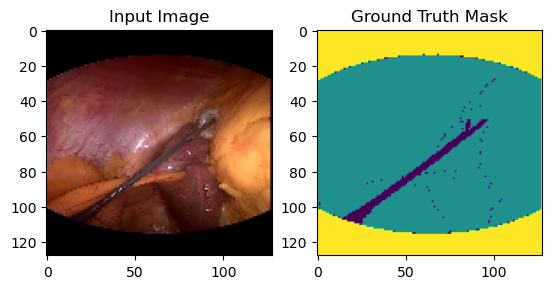

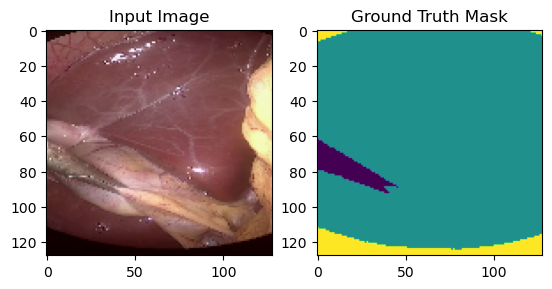

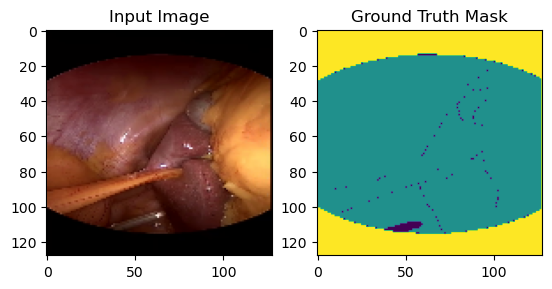

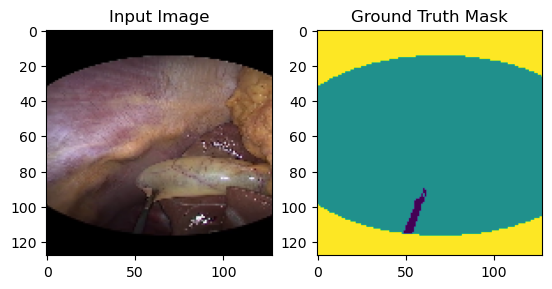

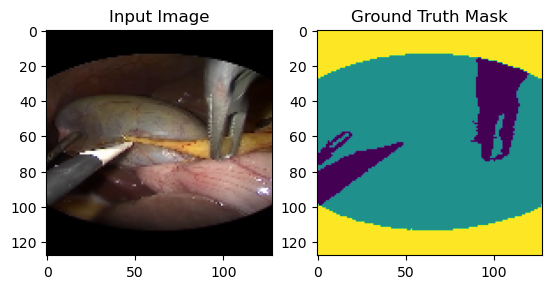

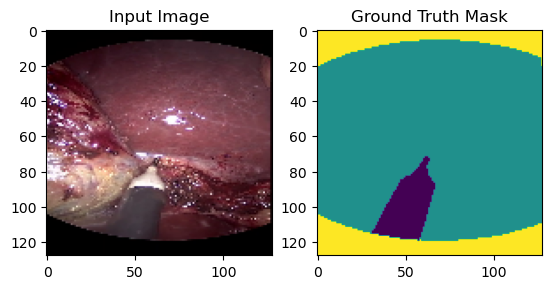

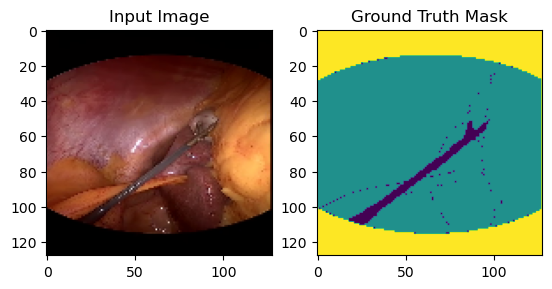

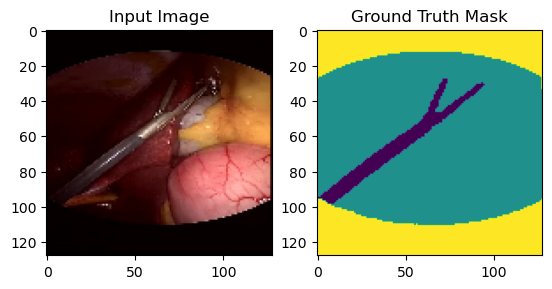

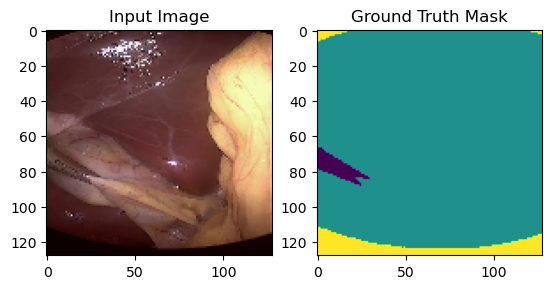

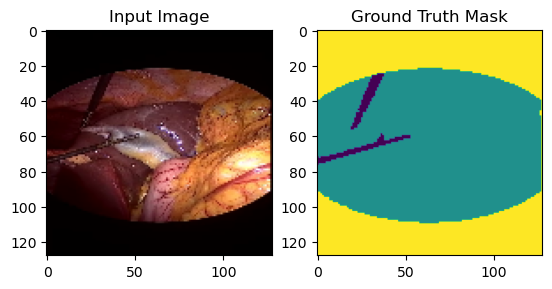

In [4]:
from torchvision.transforms import Grayscale


# Split the dataset into train, validation and test sets
train_split = 0.7
val_split = 0.2
test_split = 0.1

# batch size
batch_size = 50

# random seed
random_seed = 42

# num workers
num_workers = 0


# Augmentation transform
augmentation = ImageMaskTransform(flip_prob=0.5)

# Standard transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128))
])

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the dataset with augmentation
dataset = ImageDataset(img_dataset, mask_dataset, transform=transform, augmentation=augmentation)


print("Dataset Size: {}".format(len(dataset)))

# split the dataset into train, validation and test sets
train_size = int(train_split * len(dataset))
val_size = int(val_split * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# if GPU pin memory
pin_memory = True if device == 'cuda' else False

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

# check the dataset
print("Train Dataset: {}".format(len(train_dataset)))
print("Validation Dataset: {}".format(len(val_dataset)))
print("Test Dataset: {}".format(len(test_dataset)))

# sanity check images via visualization
def visualize(data_loader):
    for batch_idx, (data, target) in enumerate(data_loader):

        data, target = data.to(device), target.to(device)

        for i in range(10):
            plt.subplot(1, 2, 1)
            plt.imshow(data[i].cpu().permute(1, 2, 0))
            plt.title("Input Image")
            plt.subplot(1, 2, 2)
            plt.imshow(target[i].cpu().argmax(dim=0))
            plt.title("Ground Truth Mask")
            plt.show()

        break

def visualizeImage(num:int ):
    img_pat = "./parsed/images/img_"+ str(num) + ".png"
    mask_pat = "./parsed/masks/img_"+ str(num) + ".png"
    img = io.imread(img_pat)
    mask = io.imread(mask_pat)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title("Ground Truth Mask")
    plt.show()

visualize(test_loader)
plt.show()




# Loss

In [5]:
class DiceLoss(torch.nn.Module):
    def __init__(self, eps=1e-7):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self, output, target):
        output = torch.sigmoid(output)
        intersection = (output * target).sum()
        union = output.sum() + target.sum()
        dice = 2.0 * intersection / (union + self.eps)
        return 1.0 - dice

def class_iou(output, target, num_classes=3):
    ious = []
    smooth = 1e-6
    output = torch.sigmoid(output)
    output = output.argmax(dim=1)
    target = target.argmax(dim=1)
    for cls in range(num_classes):

        intersection = ((output == cls) & (target == cls)).sum().float()
        union = ((output == cls) | (target == cls)).sum().float()

        if union == 0:
            ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        else:
            ious.append((intersection + smooth) / (union + smooth))

    # we want to focus on the flesh + tools (less so on the background)
    total = 0.4 * ious[0] + 0.2 * ious[1] + 0.4 * ious[2]
    total = total/3
    return total

# Model

In [6]:
# def saveModel(model, name):
#     torch.save(model.state_dict(), f"/content/gdrive/MyDrive/Colab Notebooks/savedmodels/{name}")

# def loadModel(model, name):
#     model.load_state_dict(torch.load(f"/content/gdrive/MyDrive/Colab Notebooks/savedmodels/{name}"))
#     return model

In [7]:
!pip install git+https://github.com/ternaus/TernausNet.git

  Cloning https://github.com/ternaus/TernausNet.git to /tmp/pip-req-build-cq1pt2lf
  Running command git clone --filter=blob:none --quiet https://github.com/ternaus/TernausNet.git /tmp/pip-req-build-cq1pt2lf
  Resolved https://github.com/ternaus/TernausNet.git to commit 243c7fe98db584f3dc4f46f2c5e997df718885c4
  Preparing metadata (setup.py) ... done


In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
from ternausnet.models import UNet16

class ModifiedUNet16(UNet16):
    def __init__(self, num_classes=3, pretrained=True, dropout_prob=0.2):
        super(ModifiedUNet16, self).__init__(num_classes=num_classes, pretrained=pretrained)

        print(self.encoder)
        
        # Add dropout to specific layers
        self.encoder[3].add_module('dropout', nn.Dropout2d(p=dropout_prob))  # Add dropout after the first Conv2d in the first Sequential
        self.encoder[8].add_module('dropout', nn.Dropout2d(p=dropout_prob))  # Add dropout after the first Conv2d in the second Sequential
        self.encoder[15].add_module('dropout', nn.Dropout2d(p=dropout_prob))  # Add dropout after the first Conv2d in the third Sequential
        self.encoder[22].add_module('dropout', nn.Dropout2d(p=dropout_prob))  # Add dropout after the first Conv2d in the fourth Sequential
        self.encoder[29].add_module('dropout', nn.Dropout2d(p=dropout_prob))  # Add dropout after the first Conv2d in the fifth Sequential

        # Continue with the rest of the model

model = ModifiedUNet16(num_classes=3, pretrained=True, dropout_prob=0.5)
print(model)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [9]:
def get_model(num_classes = 3):
    return UNet16(num_classes=num_classes, pretrained = True)


def check_and_load_model(model_name, num_classes=3):
    model_path = f"/content/gdrive/MyDrive/Colab Notebooks/savedmodels/{model_name}"
    if os.path.exists(model_path):
        print("Loading existing model.")
        model = get_model(num_classes)
        model = loadModel(model, model_name)
    else:
        print("No existing model found. Instantiating a new one.")
        model = get_model(num_classes)
    return model


## Utility Functions for Train and Test

In [10]:
import torch.nn as nn

def train(model,criterion,optimizer,accFunction,dataset,device,listLoss,listAcc):

    model.train()

    totalLoss = 0
    totalAcc = 0
    for batch_idx, (data, target) in enumerate(dataset):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        currLoss = loss.item()
        currAcc = accFunction(output,target)

        totalLoss += currLoss
        totalAcc += currAcc

        listLoss.append(currLoss)
        listAcc.append(currAcc)

        if batch_idx % 10 == 0:
            print("Training Batch: {} Loss: {} Acc: {}".format(batch_idx, loss.item(),currAcc))


    totalAcc /= len(dataset)
    totalLoss /= len(dataset)

    print("Training Loss: {} Accuracy: {}".format(totalLoss,totalAcc))

    return totalLoss,totalAcc.item()

def test(model,criterion,accFunction,dataset,device,listLoss,listAcc):
    model.eval()
    loss = 0
    acc = 0

    with torch.no_grad():

        acc = 0
        for batch_idx, (data,target) in enumerate(dataset):
            data,target = data.to(device),target.to(device)

            output = model(data)

            currAcc = accFunction(output,target)
            currLoss = criterion(output,target)

            listLoss.append(currLoss)
            listAcc.append(currAcc)

            acc += currAcc
            loss += currLoss
    acc /= len(dataset)
    loss /= len(dataset)

    print("Validation Loss: {} Accuracy: {}".format(loss,acc))

    return loss,acc.item()

## Full Loop

In [11]:
num_epochs = 3

# learning rate
lr = 0.001

# criterion
# criterion = DiceLoss()
criterion = nn.CrossEntropyLoss()



def trainLoop(model,scheduler,optimizer,accFunction,times):
    # Hyper parameters
    # train the model
    trainLossList = []
    trainAccList = []
    validLossList = []
    validAccList = []
    torch.cuda.empty_cache()
    model = model.to(device)
    best_valid_acc = 0.0

    for epoch in range(num_epochs):

        print("Epoch " + str(epoch)+ " ---------------------------------------------")
        currTime = datetime.datetime.now()

        trainLoss, trainAcc  = train(model, criterion, optimizer,accFunction, train_loader, device,trainLossList,trainAccList)
        validLoss, validAcc = test(model, criterion,accFunction, val_loader, device,validLossList,validAccList)
        scheduler.step()

        trainLossList.append(trainLoss)
        trainAccList.append(trainAcc)
        validLossList.append(validLoss)
        validAccList.append(validAcc)

        endTime = datetime.datetime.now() - currTime
        endTime = endTime.total_seconds() * 1000

        times.append(endTime)

        # Save the model if validation accuracy (iou score) improved
#         if validAcc > best_valid_acc:
#             best_valid_acc = validAcc
#             print("Saving new best model from epoch " + str(epoch) + " with IoU accuracy " + str(best_valid_acc))
#             saveModel(model, "best_model.pth")
        torch.cuda.empty_cache()

        print("-----------------------------------------------------------------")
    return trainLossList,trainAccList,validLossList,validAccList

## Loop For Time Analysis

In [12]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
numTimes = 1 # set this to 1 if you want to run it once

totalTimes = []

for i in range(numTimes):
    print("ROUND: " + str(i))

    model = UNet16(num_classes = 3, pretrained = True) # Beware of ordering of lines, need to create new instance

    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

    trainLossList,trainAccList,validLossList,validAccList= trainLoop(model,scheduler,optimizer,class_iou,totalTimes)
    plot(validLossList,validAccList,trainLossList,trainAccList,totalTimes)

    model.eval()
    model.to(device)

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(train_loader):

            data, target = data.to(device), target.to(device)

            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)

            for i in range(10):
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(data[i].cpu().permute(1, 2, 0))
                plt.title("Input Image")
                plt.subplot(1, 3, 2)
                plt.imshow(target[i].cpu().argmax(dim=0))
                plt.title("Ground Truth Mask")
                plt.subplot(1, 3, 3)
                plt.imshow(pred[i].cpu().squeeze())
                plt.title("Predicted Mask")
                plt.show()

            break

    print("Total Time For Round: " + str(i) + " is " + str(totalTimes[-1]) + "ms")

ROUND: 0
Epoch 0 ---------------------------------------------
Training Batch: 0 Loss: 1.1546175231576978 Acc: 0.037757016718387604
Training Batch: 10 Loss: 0.7941875792200017 Acc: 0.04501767456531525
Training Batch: 20 Loss: 0.6662579917155061 Acc: 0.046028152108192444
Training Batch: 30 Loss: 0.5858673561612875 Acc: 0.04534558951854706
Training Batch: 40 Loss: 0.40455493116219443 Acc: 0.1822407841682434
Training Batch: 50 Loss: 0.2934298729325904 Acc: 0.1807447075843811
Training Batch: 60 Loss: 0.40860175699927753 Acc: 0.10312759876251221
Training Batch: 70 Loss: 0.2606727401296397 Acc: 0.188462495803833
Training Batch: 80 Loss: 0.2461148463095684 Acc: 0.18252281844615936
Training Batch: 90 Loss: 0.20252309516335287 Acc: 0.19059054553508759
Training Batch: 100 Loss: 0.19958494329420964 Acc: 0.19434985518455505
Training Batch: 110 Loss: 0.12229539947725983 Acc: 0.20260083675384521
Training Loss: 13.618220492882779 Accuracy: 0.1457849144935608
Validation Loss: 0.14810294669993881 Accur

NameError: name 'plot' is not defined

## Plot

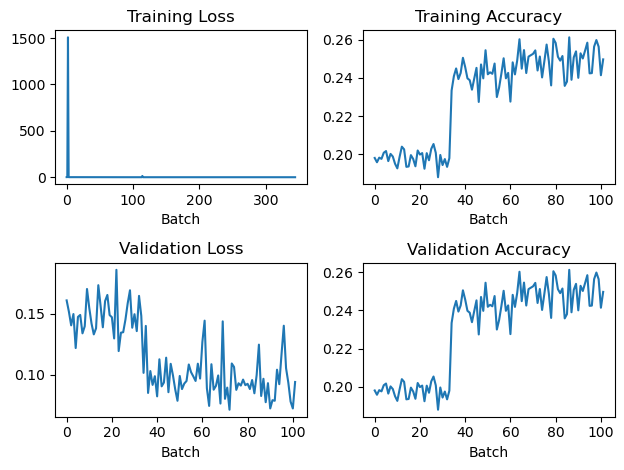

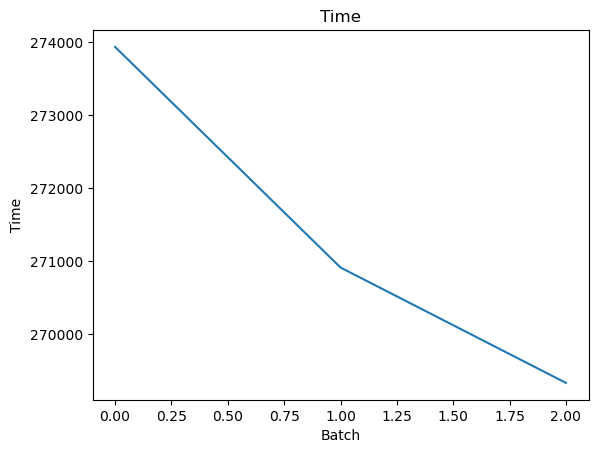

In [14]:
def plot(validLossList,validAccList,trainLossList,trainAccList, times):
        # convert to tensor
    validLossList = torch.tensor(validLossList)
    validAccList = torch.tensor(validAccList)
    trainLossList = torch.tensor(trainLossList)
    trainAccList = torch.tensor(trainAccList)

    # move to cpu
    validLossList = validLossList.cpu()
    validAccList = validAccList.cpu()
    trainLossList = trainLossList.cpu()
    trainAccList = validAccList.cpu()

    # convert back to list
    validLossList = validLossList.tolist()
    validAccList = validAccList.tolist()

    # plot the loss and accuracy in 2 by 2 grid

    plt.subplot(2, 2, 1)
    plt.plot(trainLossList)
    plt.title("Training Loss")
    plt.xlabel("Batch")

    plt.subplot(2, 2, 2)
    plt.plot(trainAccList)
    plt.title("Training Accuracy")
    plt.xlabel("Batch")

    plt.subplot(2, 2, 3)
    plt.plot(validLossList)
    plt.title("Validation Loss")
    plt.xlabel("Batch")

    plt.subplot(2, 2, 4)
    plt.plot(validAccList)
    plt.title("Validation Accuracy")
    plt.xlabel("Batch")

    plt.tight_layout()
    plt.show()

    # plot times
    plt.plot(times)
    plt.title("Time")
    plt.xlabel("Batch")
    plt.ylabel("Time")
    plt.show()

plot(validLossList,validAccList,trainLossList,trainAccList,totalTimes)


In [ ]:
# Usage
model_name = "best_model.pth"
model = check_and_load_model(model_name, num_classes=3)

## Test Output

In [ ]:
testLossList = []
testAccList = []
testCriterion = nn.CrossEntropyLoss()

testCriterion = nn.CrossEntropyLoss()



currTime = datetime.datetime.now()
test(model, testCriterion,class_iou, test_loader, device,testLossList,testAccList)
endTime  = datetime.datetime.now() - currTime


testLossList = torch.tensor(testLossList)
testAccList = torch.tensor(testAccList)

# move to cpu
testLossList = testLossList.cpu()
testAccList = testAccList.cpu()

# convert to numpy
testLossList = np.array(testLossList)
testAccList = np.array(testAccList)

# Averages
print("Test Loss: {} Test Accuracy: {}".format(sum(testLossList)/len(testLossList),sum(testAccList)/len(testAccList)))

# Inference Time
endTime = endTime.total_seconds() * 1000
print("Inference Time: {}ms".format(endTime))

# Standard Deviation
print("Standard Deviation: {}".format(np.std(testLossList)))
print("Standard Deviation: {}".format(np.std(testAccList)))

## Stats

In [ ]:
print(totalTimes)

# Average Time
print("Average Time (ms): {}".format(sum(totalTimes)/len(totalTimes)))

# Standard Deviation
print("Standard Deviation: {}".format(np.std(totalTimes)))

# Visualize Examples

In [ ]:
# visualize examples 10

def visualize(data_loader):
    for batch_idx, (data, target) in enumerate(data_loader):

        data, target = data.to(device), target.to(device)

        for i in range(10):
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(data[i].cpu().permute(1, 2, 0))
            plt.title("Input Image")
            plt.subplot(1, 3, 2)
            plt.imshow(target[i].cpu().argmax(dim=0))
            plt.title("Ground Truth Mask")

            plt.show()

        break
# visualize(test_loader)


model.eval()
model.to(device)

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)

        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)

        for i in range(10):
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(data[i].cpu().permute(1, 2, 0))
            plt.title("Input Image")
            plt.subplot(1, 3, 2)
            plt.imshow(target[i].cpu().argmax(dim=0))
            plt.title("Ground Truth Mask")
            plt.subplot(1, 3, 3)
            plt.imshow(pred[i].cpu().squeeze())
            plt.title("Predicted Mask")
            plt.show()

        break


## Results Comparison

In [ ]:
from skimage.transform import resize


# Define the transform to first convert to PIL Image, then resize
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert back to tensor after resizing
    transforms.Resize((128, 128))
])

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the dataset with augmentation
dataset = ImageDataset("/content/sample_data/img", "/content/sample_data/mask", transform=transform, augmentation=None)
loader = DataLoader(dataset, batch_size=2, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
model.eval()
model.to(device)

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(loader):

        data, target = data.to(device), target.to(device)

        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)

        for i in range(10):
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(data[i].cpu().permute(1, 2, 0))
            plt.title("Input Image")
            plt.subplot(1, 3, 2)
            plt.imshow(target[i].cpu().argmax(dim=0))
            plt.title("Ground Truth Mask")
            plt.subplot(1, 3, 3)
            plt.imshow(pred[i].cpu().squeeze())
            plt.title("Predicted Mask")
            plt.show()

        break



test loss:  cross entropy and iou, decision matrix
script to get runtimes, train loss validation loss, accuracies, test loss, test accuracy

test loss cross entropy
test accuracy is iou


std for time
std for accuracy and test loss

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


# Example data in a dictionary format
data = {
    'Model Name': ['DeepLab V3', 'TerausNet'],
    'Test Loss': [0.03, 0.05],
    'Test Loss Std': [0.003, 0.02],
    'Test Acc': [0.28, 0.29],
    'Test Acc Std': [0.004, 0.005],
    'Inference Time (ms)': [56275.315, 49227.799]
}

# Convert dictionary to DataFrame
df = pd.DataFrame(data)


# Plot Test Loss with standard deviation
plt.bar(df['Model Name'], df['Test Loss'], yerr=df['Test Loss Std'], capsize=5)
plt.title('Test Loss with Standard Deviation')
plt.xlabel('Model Name')
plt.ylabel('Test Loss')
plt.show()

# Plot Test Accuracy with standard deviation
plt.bar(df['Model Name'], df['Test Acc'], yerr=df['Test Acc Std'], capsize=5)
plt.title('Test Accuracy with Standard Deviation')
plt.xlabel('Model Name')
plt.ylabel('Test Accuracy')
plt.show()


# Plot Inference Time without standard deviation
plt.bar(df['Model Name'], df['Inference Time (ms)'])
plt.title('Inference Time (ms)')
plt.xlabel('Model Name')
plt.ylabel('Inference Time (ms)')
plt.show()


